# Expectile Regression

# Imports

In [12]:
from xgboostlss.model import *
from xgboostlss.distributions.Expectile import *
from xgboostlss.datasets.data_loader import load_simulated_gaussian_data

import multiprocessing
import plotnine
from plotnine import *
plotnine.options.figure_size = (20, 10)

# Data

In [2]:
# The data is a simulated Gaussian as follows, where x is the only true feature and all others are noise variables
    # loc = 10
    # scale = 1 + 4*((0.3 < x) & (x < 0.5)) + 2*(x > 0.7)

train, test = load_simulated_gaussian_data()
n_cpu = multiprocessing.cpu_count()

X_train, y_train = train.filter(regex="x"), train["y"].values
X_test, y_test = test.filter(regex="x"), test["y"].values

dtrain = xgb.DMatrix(X_train, label=y_train, nthread=n_cpu)
dtest = xgb.DMatrix(X_test, nthread=n_cpu)

# Expectile Specification

In [3]:
xgblss = XGBoostLSS(
    Expectile(stabilization="None",              # Options are "None", "MAD", "L2".
              expectiles = [0.05, 0.95],         # List of expectiles to be estimated, in increasing order.
              penalize_crossing = True           # Whether to include a penalty term to discourage crossing of expectiles.
              )    
)

# Hyper-Parameter Optimization

In [4]:
# Any XGBoost hyperparameter can be tuned, where the structure of the parameter dictionary needs to be as follows:

# Float/Int sample_type
# {"param_name": ["sample_type", low, high, log]}
# sample_type: str, Type of sampling, e.g., "float" or "int"
# low: int, Lower endpoint of the range of suggested values
# high: int, Upper endpoint of the range of suggested values
# log: bool, Flag to sample the value from the log domain or not
# Example: {"eta": "float", low=1e-5, high=1, log=True]}

# Categorical sample_type
# {"param_name": ["sample_type", ["choice1", "choice2", "choice3", "..."]]}
# sample_type: str, Type of sampling, either "categorical"
# choice1, choice2, choice3, ...: str, Possible choices for the parameter
# Example: {"booster": ["categorical", ["gbtree", "dart"]]}

# For parameters without tunable choice (this is needed if tree_method = "gpu_hist" and gpu_id needs to be specified)
# {"param_name": ["none", [value]]},
# param_name: str, Name of the parameter
# value: int, Value of the parameter
# Example: {"gpu_id": ["none", [0]]}

# Depending on which parameters are optimized, it might happen that some of them are not used, e.g., when {"booster":  ["categorical", ["gbtree", "gblinear"]]} and {"max_depth": ["int", 1, 10, False]} are
# specified, max_depth is not used when gblinear is sampled, since it has no such argument.

param_dict = {
    "eta":              ["float", {"low": 1e-5,   "high": 1,     "log": True}],
    "max_depth":        ["int",   {"low": 1,      "high": 10,    "log": False}],
    "gamma":            ["float", {"low": 1e-8,   "high": 40,    "log": True}],
    "subsample":        ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "colsample_bytree": ["float", {"low": 0.2,    "high": 1.0,   "log": False}],
    "min_child_weight": ["float", {"low": 1e-8,   "high": 500,   "log": True}],
    "booster":          ["categorical", ["gbtree"]],
    # "tree_method":    ["categorical", ["auto", "approx", "hist", "gpu_hist"]],
    # "gpu_id":         ["none", [0]]
}

np.random.seed(123)
opt_param = xgblss.hyper_opt(param_dict,
                             dtrain,
                             num_boost_round=100,        # Number of boosting iterations.
                             nfold=5,                    # Number of cv-folds.
                             early_stopping_rounds=20,   # Number of early-stopping rounds
                             max_minutes=10,             # Time budget in minutes, i.e., stop study after the given number of minutes.
                             n_trials=None,              # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                             silence=False,              # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.
                             seed=123,                   # Seed used to generate cv-folds.
                             hp_seed=None                # Seed for random number generator used in the Bayesian hyperparameter search.
                             )

[I 2023-05-18 07:44:34,783] A new study created in memory with name: XGBoostLSS Hyper-Parameter Optimization
C:\Users\maerzale\.virtualenvs\XGBoostLSS-vIPRRz-M\lib\site-packages\optuna\progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


   0%|          | 00:00/10:00

[I 2023-05-18 07:44:39,300] Trial 0 finished with value: 3849.6137206000008 and parameters: {'eta': 0.08271379019528409, 'max_depth': 2, 'gamma': 3.75303243021132e-08, 'subsample': 0.7583110772385693, 'colsample_bytree': 0.7712601401265677, 'min_child_weight': 12.05931834108896, 'booster': 'gbtree'}. Best is trial 0 with value: 3849.6137206000008.
[I 2023-05-18 07:44:45,975] Trial 1 finished with value: 4910.7698244 and parameters: {'eta': 1.7544244180335518e-05, 'max_depth': 6, 'gamma': 0.004467947764901467, 'subsample': 0.3135576617792821, 'colsample_bytree': 0.9569717279128798, 'min_child_weight': 0.017485979149742367, 'booster': 'gbtree'}. Best is trial 0 with value: 3849.6137206000008.
[I 2023-05-18 07:44:52,558] Trial 2 finished with value: 4094.982373 and parameters: {'eta': 0.011635867248966446, 'max_depth': 4, 'gamma': 1.6807209198451994e-06, 'subsample': 0.29862014858022196, 'colsample_bytree': 0.6775444032099875, 'min_child_weight': 0.0716153752583224, 'booster': 'gbtree'}. 

# Model Training

In [5]:
np.random.seed(123)

opt_params = opt_param.copy()
n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

# Train Model with optimized hyperparameters
xgblss.train(opt_params,
             dtrain,
             num_boost_round=n_rounds
             )

# Prediction

In [6]:
# Predicted expectiles
pred_expectile = xgblss.predict(dtest, pred_type="expectiles")

In [7]:
pred_expectile.head()

,expectile_0.05,expectile_0.95
0,6.623859,13.174365
1,6.623859,13.190308
2,9.022786,11.075418
3,4.436906,14.815821
4,6.623859,13.414122


# SHAP Interpretability

C:\Users\maerzale\.virtualenvs\XGBoostLSS-vIPRRz-M\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
C:\Users\maerzale\.virtualenvs\XGBoostLSS-vIPRRz-M\lib\site-packages\numpy\lib\function_base.py:2855: RuntimeWarning: invalid value encountered in divide


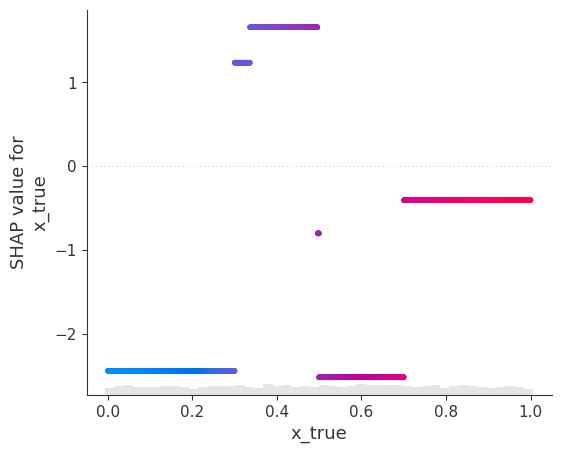

In [8]:
# Partial Dependence Plot of how x acts on selected expectile 
xgblss.expectile_plot(X_test,
                      expectile="expectile_0.95",
                      feature="x_true",
                      plot_type="Partial_Dependence")

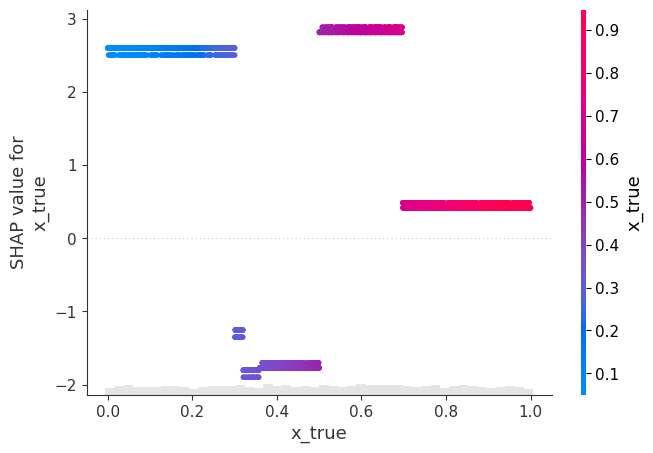

In [9]:
# Partial Dependence Plot of how x acts on selected expectile 
xgblss.expectile_plot(X_test,
                      expectile="expectile_0.05",
                      feature="x_true",
                      plot_type="Partial_Dependence")

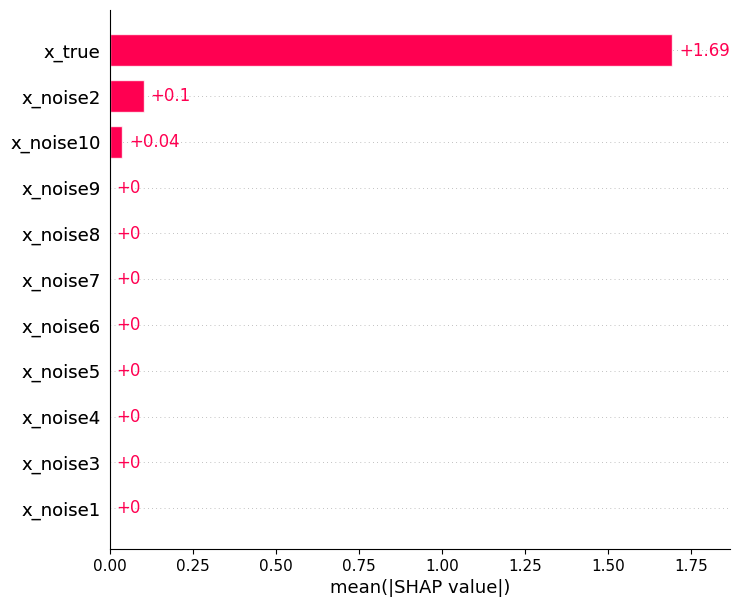

In [10]:
# Global Feature Importance of selected expectile
xgblss.expectile_plot(X_test,
                      expectile="expectile_0.95",
                      plot_type="Feature_Importance")

# Plot of Actual vs. Predicted Expectiles

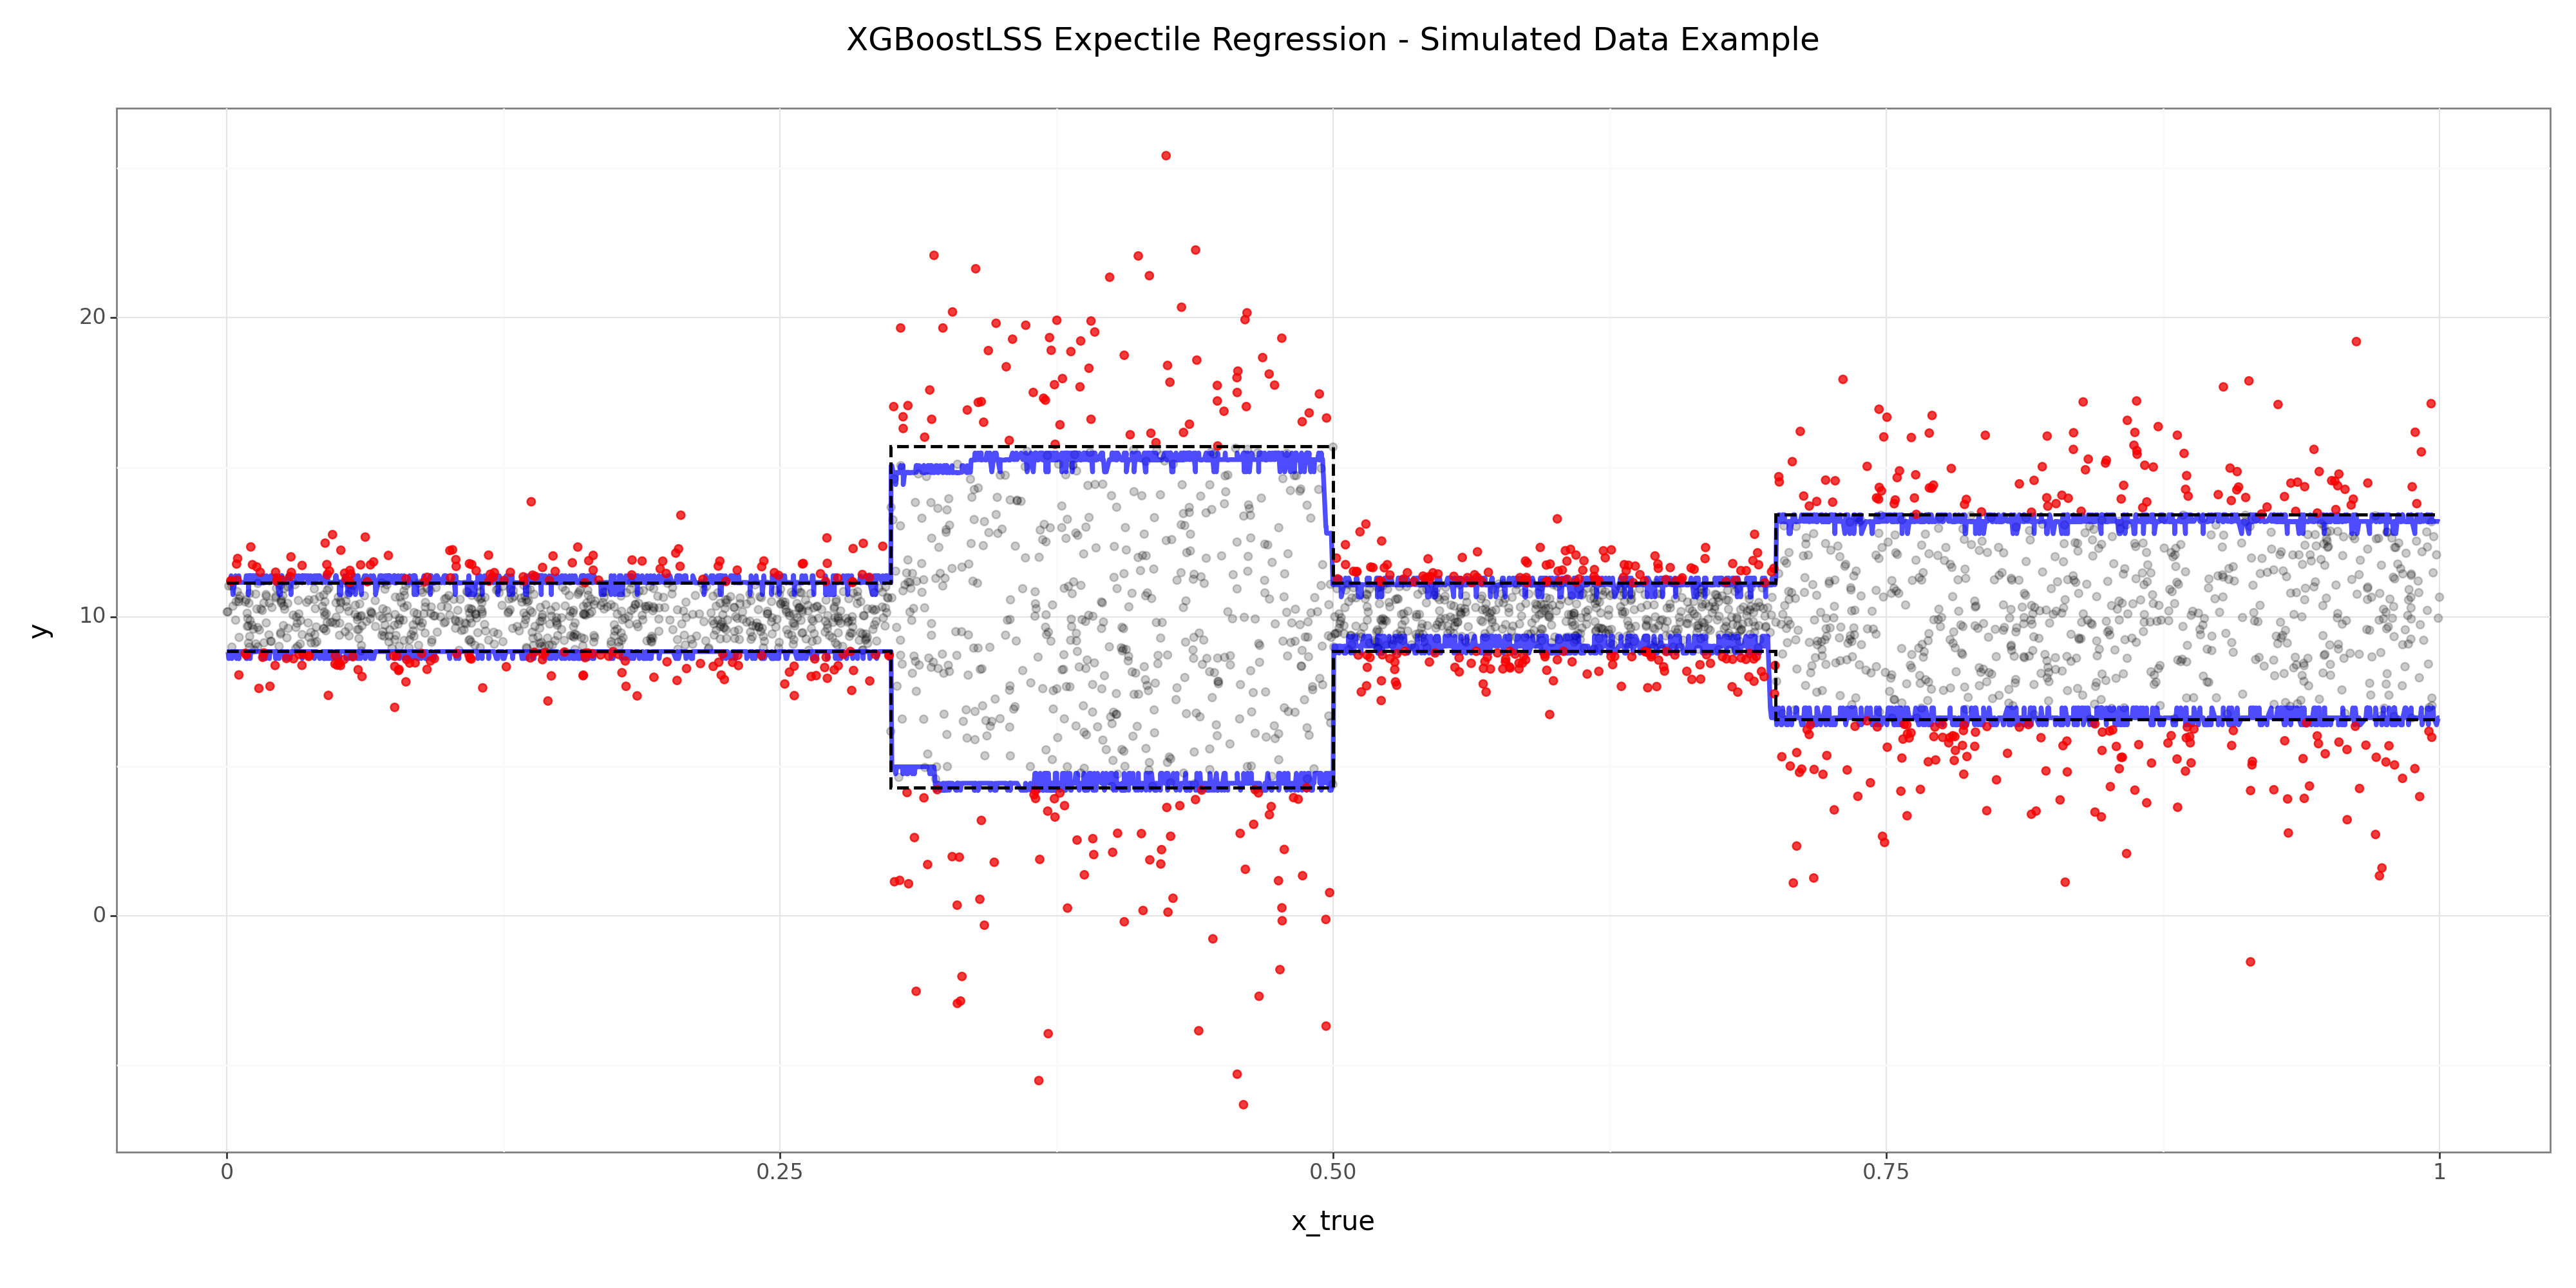

<Figure Size: (2000 x 1000)>

In [11]:
np.random.seed(123)

###
# Actual Expectiles
###
y_loc = np.array([10])
y_scale = np.array([1 + 4*((0.3 < test["x_true"].values) & (test["x_true"].values < 0.5)) + 2*(test["x_true"].values > 0.7)])
tau_lower = np.array([xgblss.dist.tau[0]])
tau_upper = np.array([xgblss.dist.tau[1]])

# Calculates exact expectiles assuming a Normal distribution
expectile_lb = expectile_norm(tau=tau_lower,
                              m=y_loc,
                              sd=y_scale).reshape(-1,)
expectile_ub =  expectile_norm(tau=tau_upper,
                               m=y_loc,
                               sd=y_scale).reshape(-1,)

test["expect"] = np.where(test["y"].values < expectile_lb, 0, np.where(test["y"].values < expectile_ub, 1, 2))
test["alpha"] = np.where(test["y"].values <= expectile_lb, 1, np.where(test["y"].values >= expectile_ub, 1, 0))
df_expectiles = test[test["alpha"] == 1]

# Lower Bound
yl = list(set(expectile_lb))
yl.sort()
yl = [yl[2],yl[0],yl[2],yl[1],yl[1]]
sfunl = pd.DataFrame({"x_true":[0, 0.3, 0.5, 0.7, 1],
                      "y":yl})

# Upper Bound
yu = list(set(expectile_ub))
yu.sort()
yu = [yu[0],yu[2],yu[0],yu[1],yu[1]]
sfunu = pd.DataFrame({"x_true":[0, 0.3, 0.5, 0.7, 1],
                      "y":yu})



###
# Forecasted Expectiles
###
test["lb"] = pred_expectile.iloc[:,0]
test["ub"] = pred_expectile.iloc[:,1]



###
# Plot
###
(ggplot(test,
        aes("x_true",
            "y")) +
 geom_point(alpha = 0.2, color = "black", size = 2) +
 theme_bw(base_size=15) +
 theme(legend_position="bottom",
       plot_title = element_text(hjust = 0.5)) +
 labs(title = "XGBoostLSS Expectile Regression - Simulated Data Example")  +
 geom_line(aes("x_true",
               "ub"),
           size = 1.5,
           color = "blue",
           alpha = 0.7) +
 geom_line(aes("x_true",
               "lb"),
           size = 1.5,
           color = "blue",
           alpha = 0.7) +
 geom_point(df_expectiles,
            aes("x_true",
                "y"),
            color = "red",
            alpha = 0.7,
            size = 2) +
 geom_step(sfunl,
           aes("x_true",
               "y"),
           size = 1,
           linetype = "dashed")  +
 geom_step(sfunu,
           aes("x_true",
               "y"),
           size = 1,
           linetype = "dashed")
)